In [1]:
import numpy as np
import pandas as pd
import scipy as sc 
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.feature_selection import SelectFromModel, RFE, f_regression, SelectKBest

#Tuning 
from sklearn.model_selection import GridSearchCV, learning_curve, KFold, ParameterGrid, train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelBinarizer, OneHotEncoder

#Metrics

from sklearn.metrics import confusion_matrix, classification_report, f1_score, recall_score, roc_auc_score, precision_score,accuracy_score,roc_curve

#Option d'affichage 

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

In [2]:
with open('data/data_clean.pkl', 'rb') as f:
    my_unpickle = pickle.Unpickler(f)
    df_cleaned = my_unpickle.load()

In [3]:
data =  df_cleaned.copy()

In [4]:
data.head()

,structureId,classification,experimentalTechnique,macromoleculeType,residueCount,resolution,structureMolecularWeight,crystallizationMethod,crystallizationTempK,densityMatthews,densityPercentSol,pdbxDetails,phValue,publicationYear,chainId,sequence
0,100D,dna-rna hybrid,X-RAY DIFFRACTION,DNA/RNA Hybrid,20,1.90,6360.30,vapor diffusion hanging drop,NaN,1.78,30.89,"pH 7.00, VAPOR DIFFUSION, HANGING DROP",neutre,1994.0,A,CCGGCGCCGG
1,100D,dna-rna hybrid,X-RAY DIFFRACTION,DNA/RNA Hybrid,20,1.90,6360.30,vapor diffusion hanging drop,NaN,1.78,30.89,"pH 7.00, VAPOR DIFFUSION, HANGING DROP",neutre,1994.0,B,CCGGCGCCGG
2,101D,dna,X-RAY DIFFRACTION,DNA,24,2.25,7939.35,NaN,NaN,2.00,38.45,NaN,neutre,1995.0,A,CGCGAATTCGCG
3,101D,dna,X-RAY DIFFRACTION,DNA,24,2.25,7939.35,NaN,NaN,2.00,38.45,NaN,neutre,1995.0,B,CGCGAATTCGCG
4,101M,oxygen transport,X-RAY DIFFRACTION,Protein,154,2.07,18112.80,NaN,NaN,3.09,60.20,"3.0 M AMMONIUM SULFATE, 20 MM TRIS, 1MM EDTA, ...",basique,1999.0,A,MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDR...


####  Features Engineering

In [5]:
# Target feature
counts = data.classification.value_counts()
types = np.asarray(counts[counts>5000].index)
df = data[data.classification.isin(types)].copy()

#class_dict = dict()
#count = 0

#classes = df['classification'].value_counts().items()

#for cat, num in classes:
#   class_dict[cat] = count
 #   count +=1

In [6]:
#class_dict

In [8]:
df['target'] = df.classification

In [9]:
# crystallizationMethod
cr_df = (df.crystallizationMethod.value_counts(ascending = False, normalize=True) *100)

methods={}
for method, value in zip(cr_df.index, cr_df.values):
    if value < 1.90 :
        methods[method] = 'others_cryst_method'
    else :
        methods[method] = method

df['crystallizationMethod'] = df.crystallizationMethod.map(methods)

In [10]:
# experimentalTechnique 
percent_exp_tech = (df.experimentalTechnique.value_counts(normalize = True)*100)
tech_mode = ['X-RAY DIFFRACTION', 'ELECTRON MICROSCOPY', 'SOLUTION NMR']

techniques = {}
for tech in percent_exp_tech.index:
    if tech not in tech_mode:
        techniques[tech] = "others_tech_exp"
    else:
        techniques[tech] = tech
        
df["experimentalTechnique"]=df.experimentalTechnique.map(techniques)

In [11]:
# macromoleculeType
macro_molec = ['Protein', 'Protein#RNA', 'Protein#DNA']

types_macro = {}
macro_percent = (df.macromoleculeType.value_counts(normalize=True)*100).index.tolist()

for macro in macro_percent:
    if macro not in macro_molec:
        types_macro[macro] = "others_macro_mol"
    else:
        types_macro[macro] = macro
        
df.macromoleculeType = df.macromoleculeType.map(types_macro)

####  Correction assymétrique des features num

In [12]:
feats = ['residueCount', 'structureMolecularWeight','densityMatthews', 'resolution']
for i in feats:
    df[i]=df[i].map(lambda i: np.log(i) if i > 0 else 0)

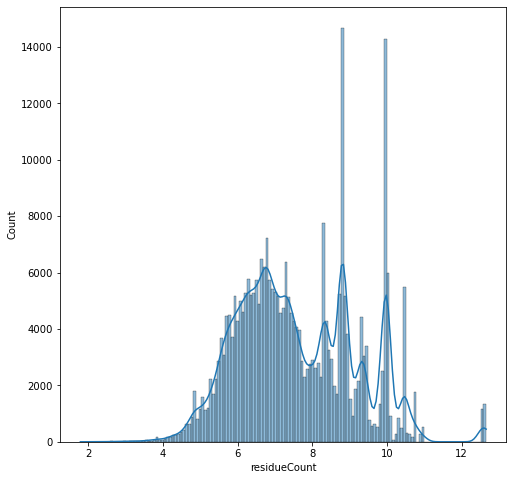

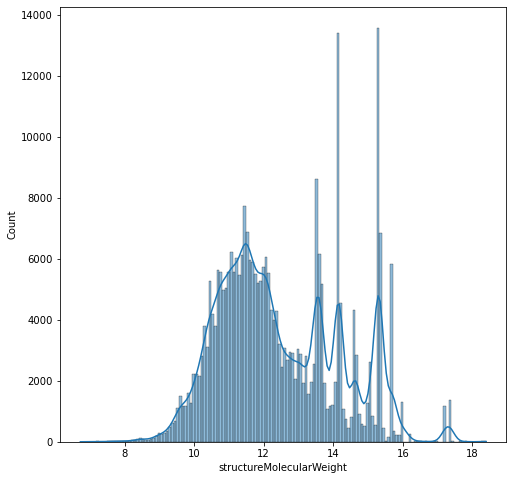

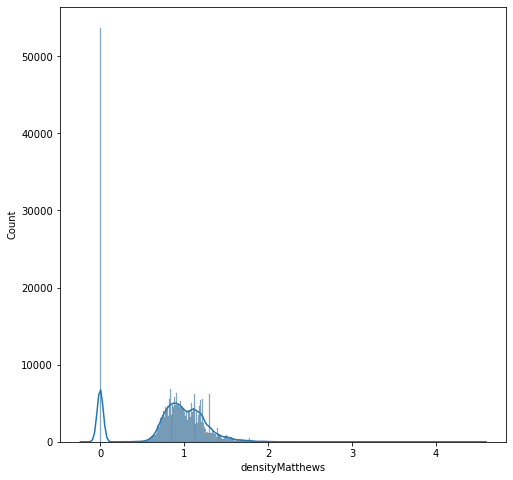

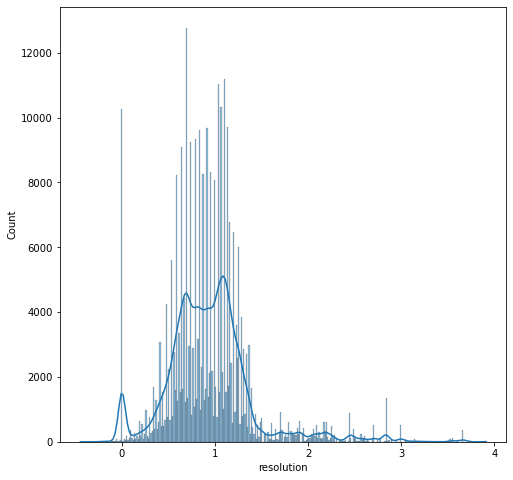

In [13]:
for i in feats:
    plt.figure(figsize = (8,8))
    sns.histplot(x = df[i], kde = True)

#### Missing values handling

In [14]:

# for numerical values replace nan by median 

df = df.fillna(df.select_dtypes(include = np.number).median())

# replace by mode
df['macromoleculeType'].fillna(df['macromoleculeType'].mode()[0], inplace = True)
df['crystallizationMethod'].fillna(df['crystallizationMethod'].mode()[0], inplace = True)

# drop other 
df = df.dropna()

In [15]:
df.shape

(250052, 17)

In [16]:
# check missing values 

pd.DataFrame({'Total': df.isna().sum(),
             'Percent': df.isna().sum()/df.shape[0],
             'Types': df.dtypes})

,Total,Percent,Types
structureId,0,0.0,object
classification,0,0.0,object
experimentalTechnique,0,0.0,object
macromoleculeType,0,0.0,object
residueCount,0,0.0,float64
resolution,0,0.0,float64
structureMolecularWeight,0,0.0,float64
crystallizationMethod,0,0.0,object
crystallizationTempK,0,0.0,float64
densityMatthews,0,0.0,float64


In [17]:
# Droping features uninterest
columns_drop = ['structureId', 'chainId', 'sequence', 'pdbxDetails', 'classification']

df = df.drop(columns=columns_drop, axis = 1)

#### Encoding categorical features 

In [18]:
data = df.drop('target', 1)

In [19]:
# Discretisation des variables catégorielles par la méthode get_dummies, option drop_first = éviter les variables colineaires
data = pd.get_dummies(data, prefix_sep= '_',columns=['experimentalTechnique', 'macromoleculeType', 'crystallizationMethod', 'phValue'],
                      drop_first=False)

#### Dimensional reduction 

In [20]:
# Scaling data 
scaler = StandardScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data), columns = data.columns)
data_scaled.head(2)

,residueCount,resolution,structureMolecularWeight,crystallizationTempK,densityMatthews,densityPercentSol,publicationYear,experimentalTechnique_ELECTRON MICROSCOPY,experimentalTechnique_X-RAY DIFFRACTION,experimentalTechnique_others_tech_exp,macromoleculeType_Protein,macromoleculeType_Protein#DNA,macromoleculeType_Protein#RNA,macromoleculeType_others_macro_mol,crystallizationMethod_microbatch,crystallizationMethod_others_cryst_method,crystallizationMethod_vapor diffusion,crystallizationMethod_vapor diffusion hanging drop,crystallizationMethod_vapor diffusion sitting drop,phValue_acide,phValue_basique,phValue_neutre
0,-0.74034,-0.3756,-0.730081,0.2343,0.075998,0.017117,-2.89747,-0.005999,0.026388,-0.025696,0.399173,-0.068446,-0.387295,-0.048467,-0.195784,-0.218961,-0.289757,0.808548,-0.554541,1.22356,-0.76977,-0.542616
1,-0.74034,-0.3756,-0.730081,0.2343,0.075998,0.017117,-2.89747,-0.005999,0.026388,-0.025696,0.399173,-0.068446,-0.387295,-0.048467,-0.195784,-0.218961,-0.289757,0.808548,-0.554541,1.22356,-0.76977,-0.542616


#### RFE (Recurent Feature Elimination Method) 

In [ ]:
# Logistic Regression Model 

In [21]:

from sklearn.linear_model import LogisticRegression
#Fiting 
model_1 = LogisticRegression()
model_1.fit(data_scaled, df['target'])

LogisticRegression()

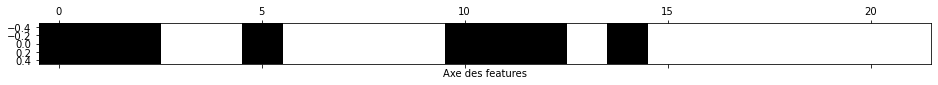

In [22]:
selector = RFE(estimator=model_1, n_features_to_select=8) 

selector.fit(data_scaled, df['target'])
mask = selector.get_support()

plt.matshow(mask.reshape(1,-1), cmap = 'gray_r')
plt.xlabel('Axe des features');

In [23]:
# Features names 

np.array(data.columns)[mask]

array(['residueCount', 'resolution', 'structureMolecularWeight',
       'densityPercentSol', 'macromoleculeType_Protein',
       'macromoleculeType_Protein#DNA', 'macromoleculeType_Protein#RNA',
       'crystallizationMethod_microbatch'], dtype=object)

####  RandomForest Method 

In [24]:
from sklearn.ensemble import RandomForestClassifier
model_2 = RandomForestClassifier(random_state=1, max_depth=10)

In [25]:
model_2.fit(data_scaled, df['target'])

RandomForestClassifier(max_depth=10, random_state=1)

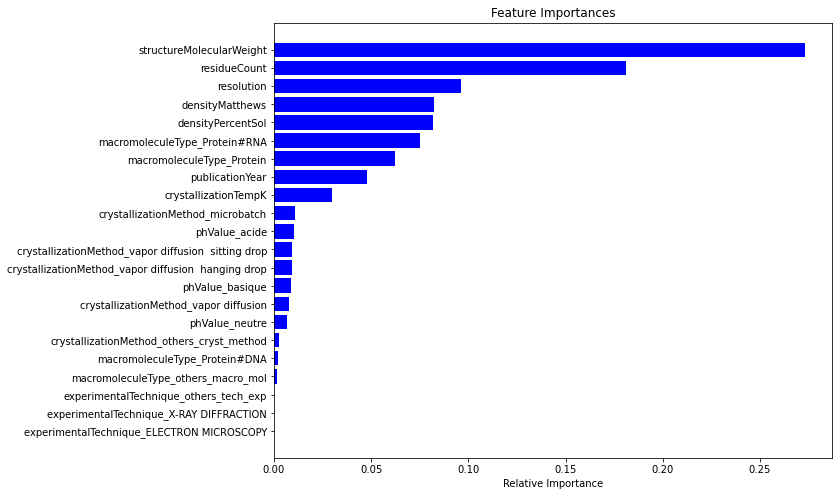

In [26]:
features = data.columns
importances = model_2.feature_importances_
indices = np.argsort(importances) #[-10:] # top 6 features
plt.figure(figsize = (10,8))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [27]:
data.columns

Index(['residueCount', 'resolution', 'structureMolecularWeight',
       'crystallizationTempK', 'densityMatthews', 'densityPercentSol',
       'publicationYear', 'experimentalTechnique_ELECTRON MICROSCOPY',
       'experimentalTechnique_X-RAY DIFFRACTION',
       'experimentalTechnique_others_tech_exp', 'macromoleculeType_Protein',
       'macromoleculeType_Protein#DNA', 'macromoleculeType_Protein#RNA',
       'macromoleculeType_others_macro_mol',
       'crystallizationMethod_microbatch',
       'crystallizationMethod_others_cryst_method',
       'crystallizationMethod_vapor diffusion',
       'crystallizationMethod_vapor diffusion  hanging drop',
       'crystallizationMethod_vapor diffusion  sitting drop', 'phValue_acide',
       'phValue_basique', 'phValue_neutre'],
      dtype='object')

#### Choice Features 

In [28]:
column = ['residueCount', 'structureMolecularWeight', 'densityMatthews',
       'densityPercentSol', 'macromoleculeType_Protein',
       'macromoleculeType_Protein#DNA', 'macromoleculeType_Protein#RNA',
       'macromoleculeType_others_macro_mol']


data = data[column]

data = data.join(df['target'])

data.shape

(250052, 9)

#### Saving data

In [29]:
with open ('data/data.pkl', 'wb') as f:
    my_pickle = pickle.Pickler(f)
    my_pickle.dump(data)